#  *Second stage*: ML
The goal is to predict `SalePrice`.<br>


The packages to apply:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
data=pd.read_csv("data_ml.csv")

In [3]:
data.shape

(1460, 172)

In [4]:
data.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.75,0.150685,0.033420,1.0,1.0,1.0,0.0,1.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.75,0.202055,0.038795,1.0,1.0,1.0,0.0,0.5,0.0,0.125,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.75,0.160959,0.046507,1.0,0.0,1.0,0.0,1.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.75,0.133562,0.038561,1.0,0.0,1.0,0.0,0.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.75,0.215753,0.060576,1.0,0.0,1.0,0.0,0.5,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Splitting dataset:

In [5]:
from sklearn.model_selection import train_test_split,cross_validate
data_train , data_test = train_test_split(data,test_size=0.2,random_state=141) 

**data_train** 

In [6]:
train_x=data_train.drop(columns="SalePrice")
train_y=data_train["SalePrice"]

**data_test**

In [7]:
test_x=data_test.drop(columns="SalePrice")
test_y=data_test["SalePrice"]

To ignore warnings:

In [8]:
#import warnings
#warnings.filterwarnings('ignore')

It will be only applyed supervised methods as follow:
- Linear Regression
- K-Nearest Neighbor
- Gradient Boosting
- Random Forest  

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

## Linear Regression 

In [10]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', LinearRegression(n_jobs=-1))])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=10,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 7.45 s


Pipeline(steps=[('scale', RobustScaler()), ('lr', LinearRegression(n_jobs=-1))])

In [11]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 20099.62


In [12]:
predict_y=lr_pipe.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 63848149219.4


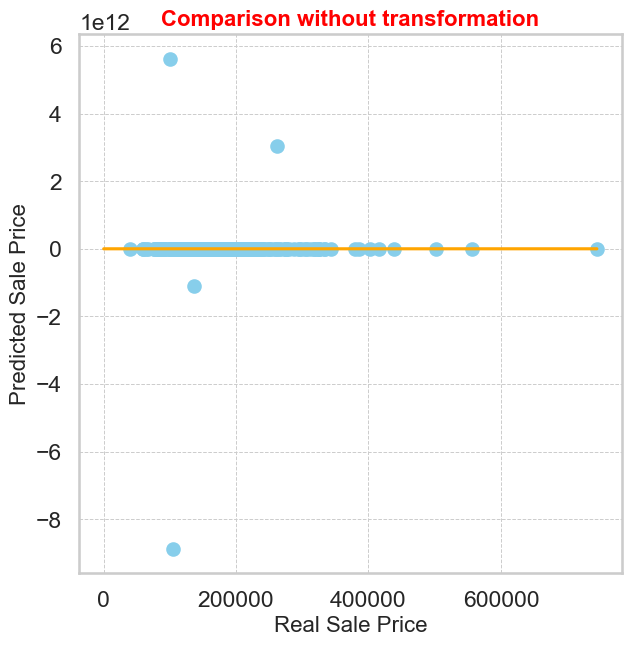

In [13]:
plt.figure(figsize=(7,7))
plt.title('Comparison without transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

To get a better model, transforming the target to logarithm scale

In [14]:
%%time
regr_trans = TransformedTargetRegressor(lr_pipe,func=np.log1p,inverse_func=np.expm1)
#fit the model to data
regr_trans.fit(test_x, test_y)

Wall time: 73.6 ms


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr',
                                                      LinearRegression(n_jobs=-1))]))

In [15]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 9004.02


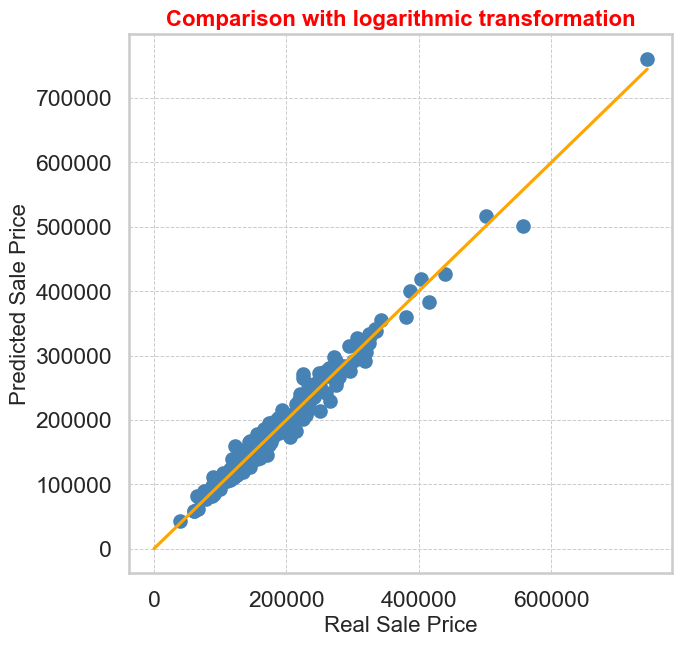

In [16]:
plt.figure(figsize=(7,7))
plt.title('Comparison with logarithmic transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## K-Nearest Neighbor

In [17]:
%%time
n_neighbors= range(3,25,2)
from sklearn.neighbors import KNeighborsRegressor

#create a knn model
knn = KNeighborsRegressor(p=1,n_jobs=-1)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.array(n_neighbors)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
knn_gscv.fit(train_x, train_y)

Wall time: 6.27 s


GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

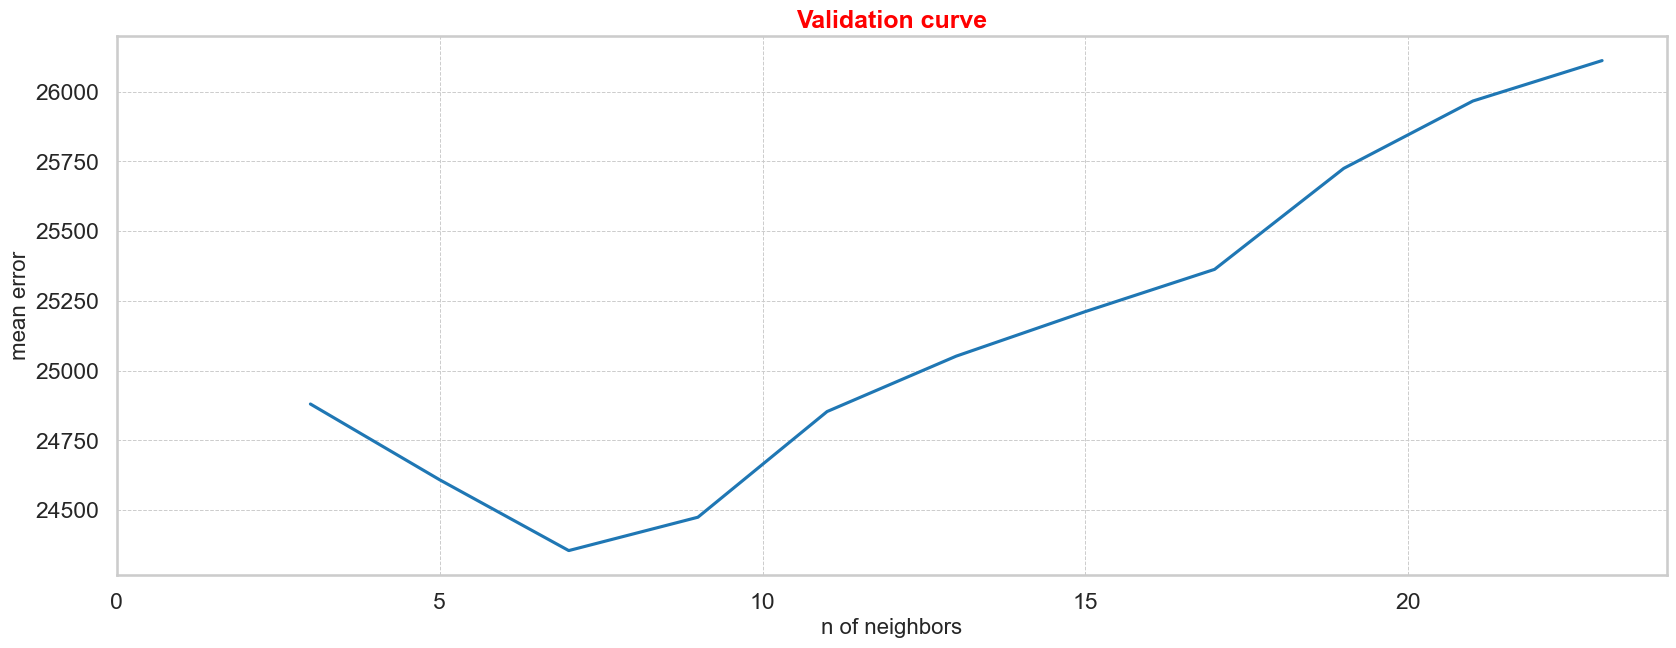

In [18]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv.cv_results_['mean_test_score']) 
plt.title('Validation curve',fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [19]:
predict_y=knn_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 24311.16


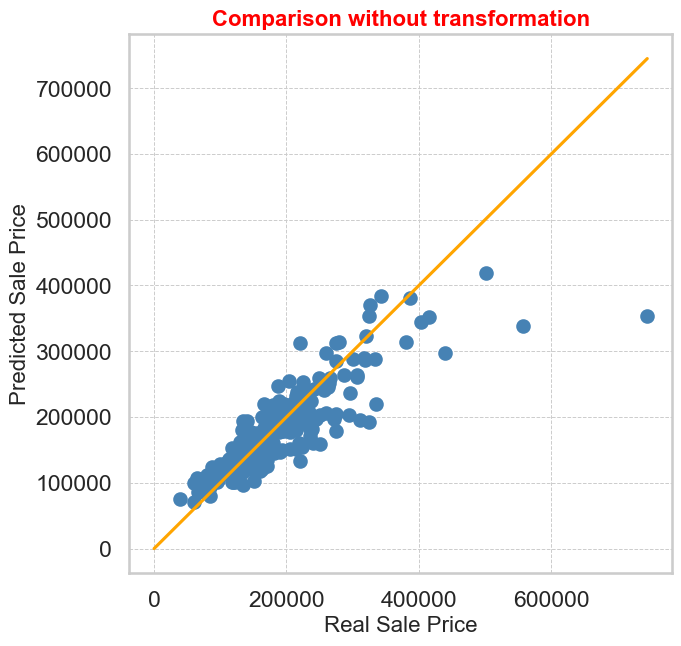

In [20]:
plt.figure(figsize=(7,7))
plt.title('Comparison without transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

When the highest sale prices that are outliers, the model doesn't perform well. To avoid that, transforming to logaritmic scale.

In [21]:
%%time
regr_trans = TransformedTargetRegressor(knn_gscv,func=np.log1p,inverse_func=np.expm1)
#fit the model to data
regr_trans.fit(test_x, test_y)

Wall time: 1.53 s


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=10,
                                                  estimator=KNeighborsRegressor(n_jobs=-1,
                                                                                p=1),
                                                  n_jobs=-1,
                                                  param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
                                                  scoring='neg_mean_absolute_error'))

In [22]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 25064.68


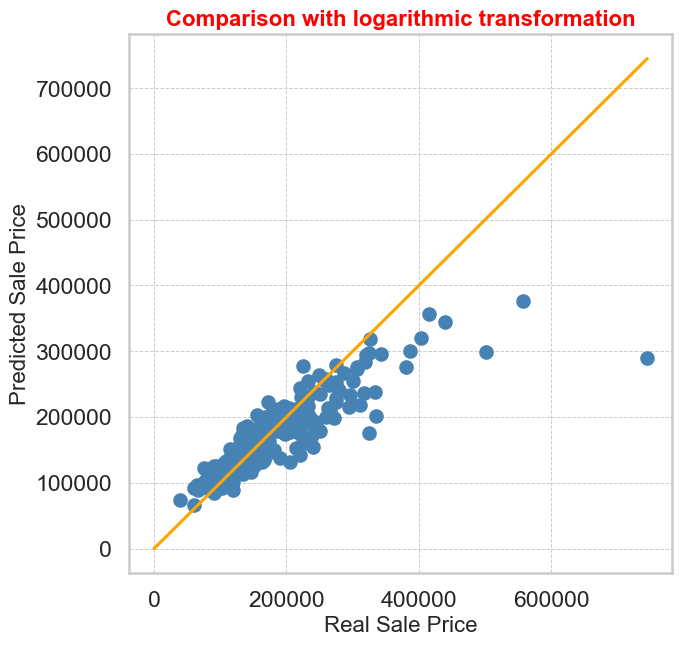

In [23]:
plt.figure(figsize=(7,7))
plt.title('Comparison with logarithmic transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

## Gradient Boosting

In [24]:
%%time
N=np.array([15,50,100,300])
from sklearn.ensemble import GradientBoostingRegressor 

#create a rf model
gb = GradientBoostingRegressor(loss='lad')
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_estimators": N}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
gb_gscv = GridSearchCV(gb, param_grid, cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
gb_gscv.fit(train_x, train_y)

Wall time: 25.4 s


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(loss='lad'), n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 300])},
             scoring='neg_mean_absolute_error')

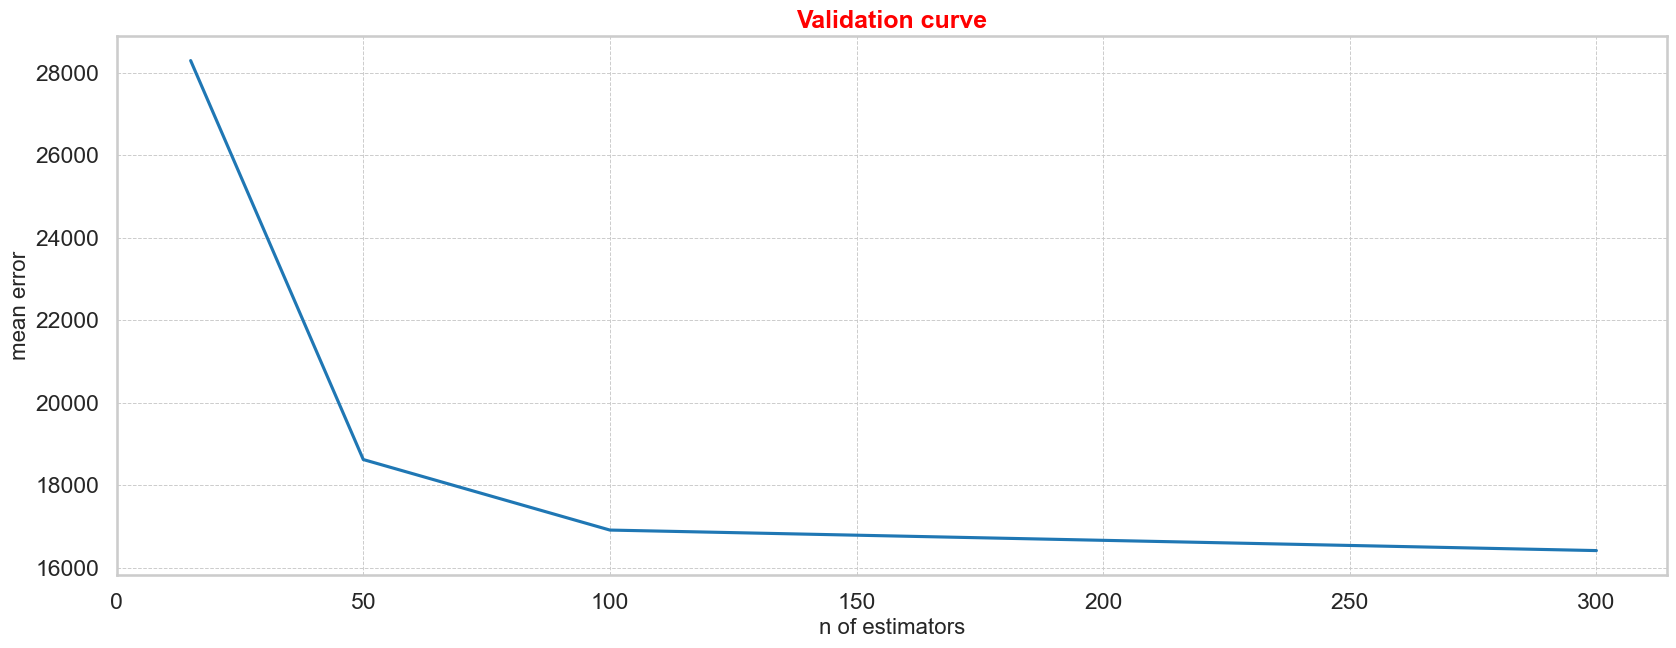

In [25]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv.cv_results_['mean_test_score']) 
plt.title('Validation curve',fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(np.arange(0,350,step=50))
plt.ylabel('mean error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [26]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 25064.68


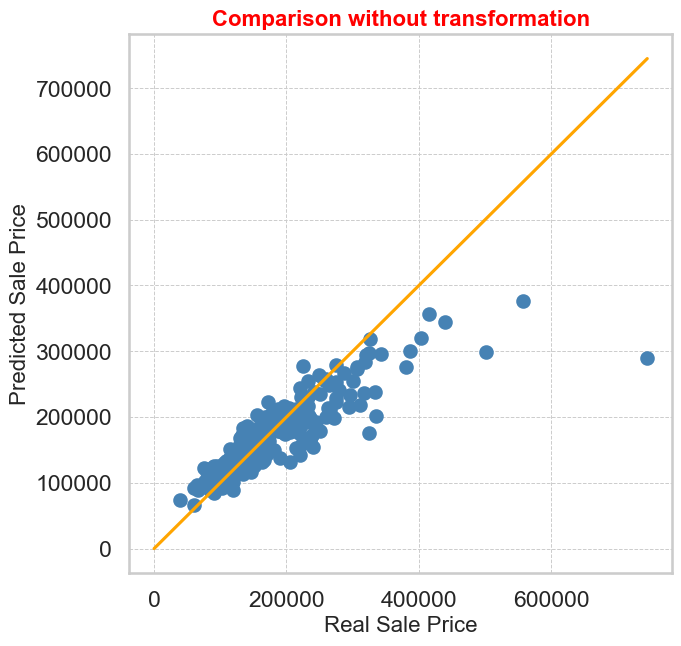

In [27]:
plt.figure(figsize=(7,7))
plt.title('Comparison without transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

In [28]:
%%time
regr_trans = TransformedTargetRegressor(gb_gscv,func=np.log1p,inverse_func=np.expm1)
#fit the model to data
regr_trans.fit(test_x, test_y)

Wall time: 10.4 s


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=10,
                                                  estimator=GradientBoostingRegressor(loss='lad'),
                                                  n_jobs=-1,
                                                  param_grid={'n_estimators': array([ 15,  50, 100, 300])},
                                                  scoring='neg_mean_absolute_error'))

In [29]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 5631.05


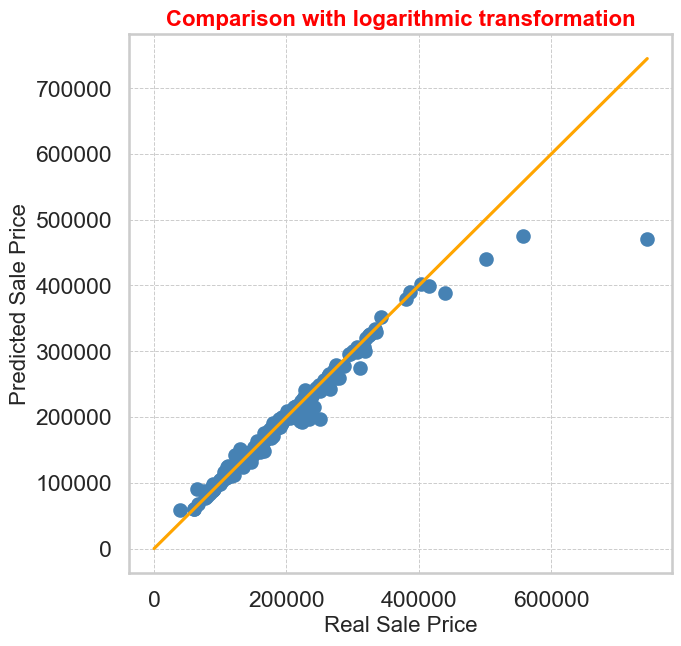

In [30]:
plt.figure(figsize=(7,7))
plt.title('Comparison with logarithmic transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()   

***The fit looks pretty good.***

## Random Forest:

In [31]:
%%time
N=np.array([15,50,100,300])
from sklearn.ensemble import RandomForestRegressor 

#create a rf model
rf = RandomForestRegressor(criterion='mae',n_jobs=-1)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_estimators": N}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
rf_gscv = GridSearchCV(rf, param_grid, cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
rf_gscv.fit(train_x, train_y)

Wall time: 11min 43s


GridSearchCV(cv=10, estimator=RandomForestRegressor(criterion='mae', n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 300])},
             scoring='neg_mean_absolute_error')

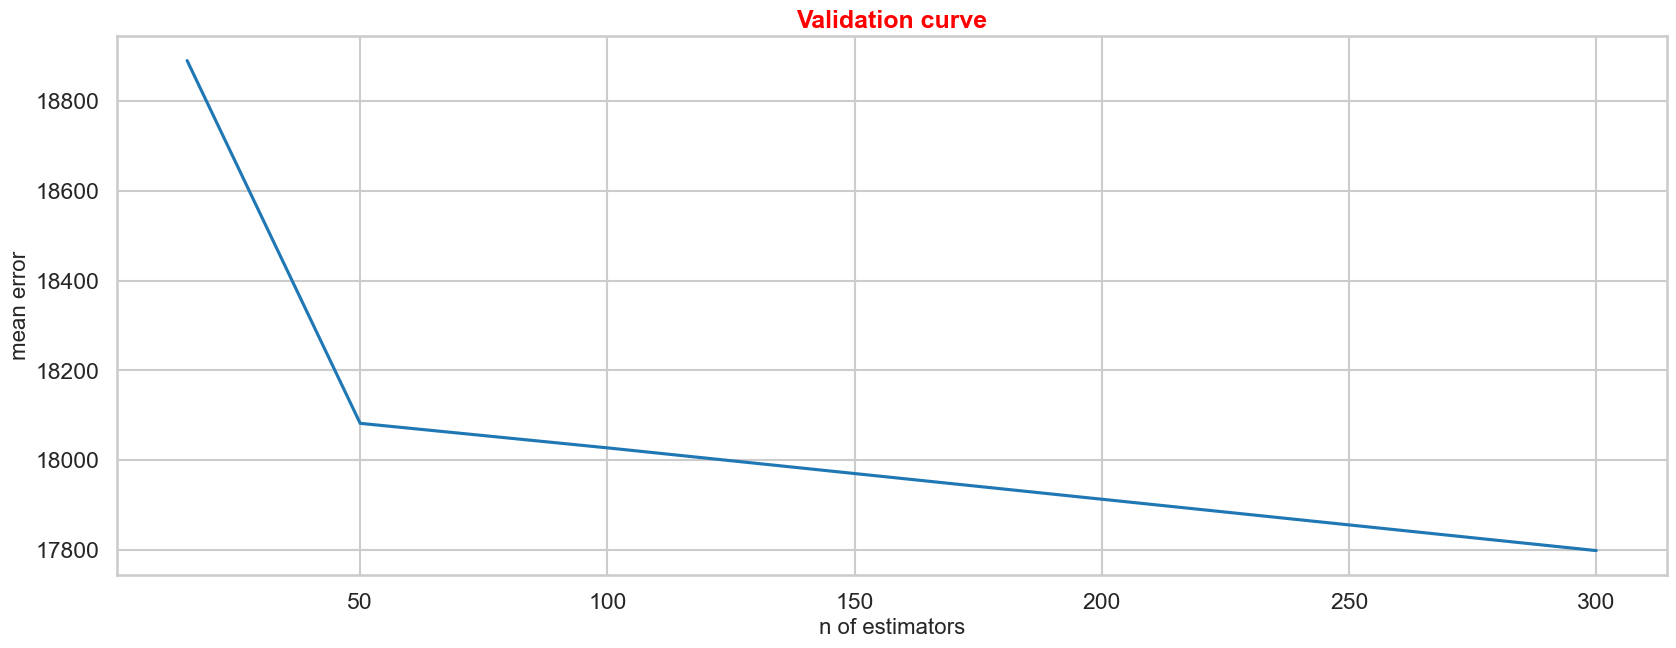

In [32]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv.cv_results_['mean_test_score']) 
plt.title('Validation curve',fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean error',fontsize=16)
plt.show() 

In [33]:
predict_y=rf_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 17324.43


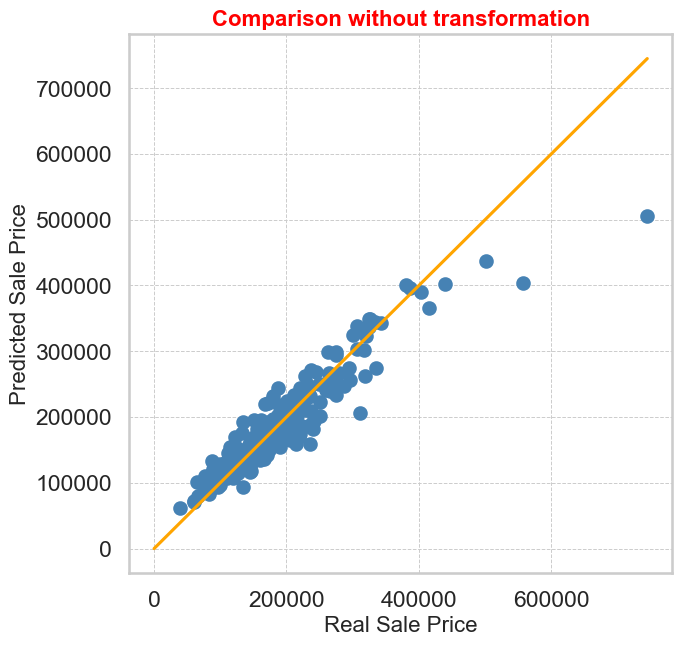

In [34]:
plt.figure(figsize=(7,7))
plt.title('Comparison without transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

In [35]:
%%time
regr_trans = TransformedTargetRegressor(rf_gscv,func=np.log1p,inverse_func=np.expm1)
#fit the model to data
regr_trans.fit(test_x, test_y)

Wall time: 1min 45s


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=10,
                                                  estimator=RandomForestRegressor(criterion='mae',
                                                                                  n_jobs=-1),
                                                  n_jobs=-1,
                                                  param_grid={'n_estimators': array([ 15,  50, 100, 300])},
                                                  scoring='neg_mean_absolute_error'))

In [36]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 7777.79


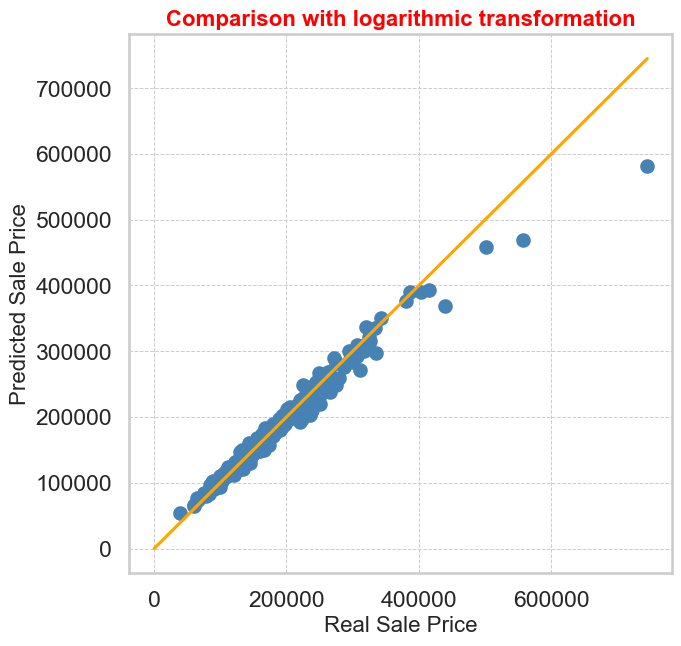

In [37]:
plt.figure(figsize=(7,7))
plt.title('Comparison with logarithmic transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## Support Vector Machine

In [38]:
%%time
degree= [5, 10, 15,20]
from sklearn.svm import SVR 

#create a rf model
svm = SVR()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"degree": degree}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(svm, param_grid, cv=10,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
svm_gscv.fit(train_x, train_y)

Wall time: 6.3 s


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

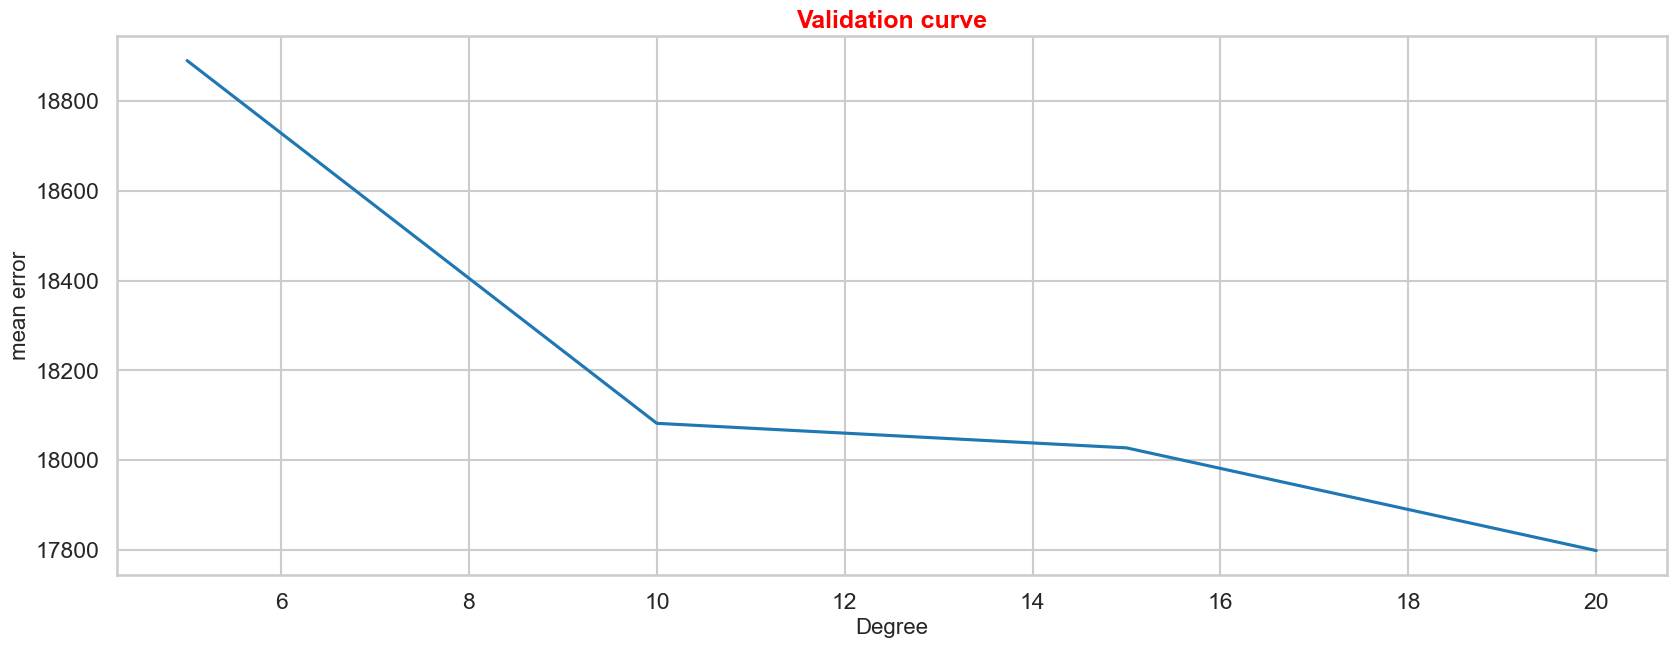

In [39]:
plt.figure(figsize=(20,7))
plt.plot(degree, -rf_gscv.cv_results_['mean_test_score']) 
plt.title('Validation curve',fontsize=18,color='red',fontweight="bold")
plt.xlabel('Degree',fontsize=16)
plt.ylabel('mean error',fontsize=16)
plt.show() 

In [40]:
predict_y=svm_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 53444.06


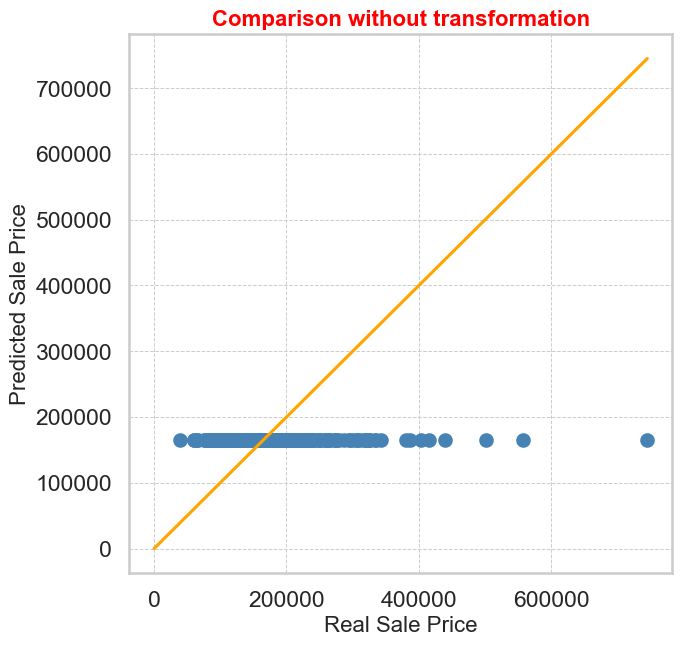

In [41]:
plt.figure(figsize=(7,7))
plt.title('Comparison without transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

In [42]:
%%time
regr_trans = TransformedTargetRegressor(svm_gscv,func=np.log1p,inverse_func=np.expm1)
#fit the model to data
regr_trans.fit(test_x, test_y)

Wall time: 430 ms


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=10, estimator=SVR(),
                                                  n_jobs=-1,
                                                  param_grid={'degree': [5, 10,
                                                                         15,
                                                                         20]},
                                                  scoring='neg_mean_absolute_error'))

In [43]:
predict_y=regr_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 13445.66


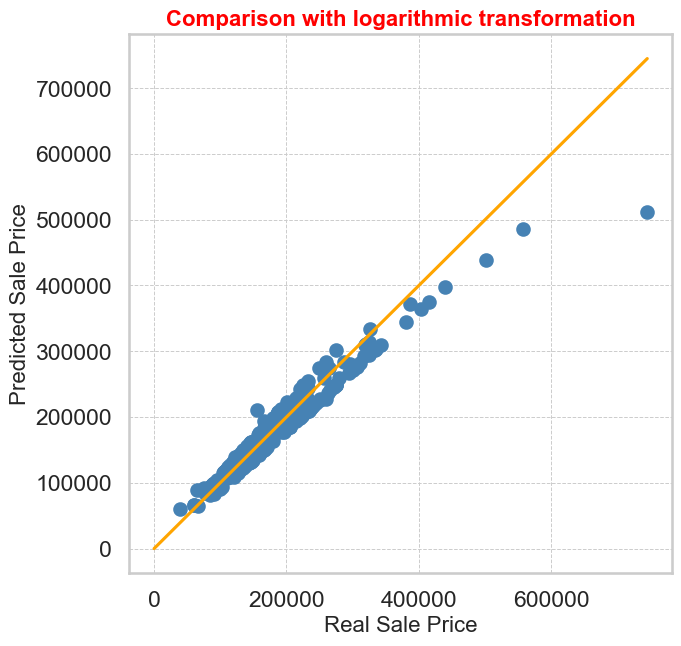

In [44]:
plt.figure(figsize=(7,7))
plt.title('Comparison with logarithmic transformation',fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

# Summary 

|Method|Calculation time (8MB RAM)|Less error with the target transformed to logarithm?|mean absolute error|
|------|----------------|---------------------------------------------|-------------------|
|Linear Regression  |8s               |yes                                         |9.004,00|
|K-Nearest Neighbor|   6,3s |no                                  |2.4311,20|          
|**Gradient Boosting**|**25,4s**                 |yes    |**5.631,85**|
|Random Forest|11m 47s            |yes                                          |7.723,40             |
|Support Vector Machine| 6,3s| yes| 13.445,70|